# EDA of the data
* Performing an EDA of the data to discover preliminary patterns and problems which we will use in our preprocessing of the data

# Importing required libraries

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler
from datetime import datetime
from tqdm.notebook import tqdm #lets us display pretty progress bars for loops
import seaborn as sns
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
import random #used for randomly selecting which plots to display (as there are a lot)

# Setting up display options for pandas

In [107]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Loading the data
* Try to load from pickle file as it is quicker to access
* If this fails, load the original CSV and save it to a pickle file
* <b>No point in doing anything with weather data as we only have 1 years worth of values so it is impossible to leverage with our chosen RNN/CNN based models to predict the next years worth of energy readings</b>
    * <b>Unless we leveraged them to produce multivariate predictions and also predicting the weathers values in order to use those as input for subsequent days: but this will likely result in worse performing energy predictions</b>
* Hence we are only looking into addInfo and consumption

In [108]:
#try to load pickle file as it is quicker
try:
    print("Loading consumption via pickle")
    df_energy = pd.read_pickle("../Data/Original_Data/consumption.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading consumption via csv")
    df_energy = pd.read_csv("../Data/Original_Data/consumption.csv")
    df_energy.to_pickle("../Data/Original_Data/consumption.pkl")

    #try to load pickle file as it is quicker
try:
    print("Loading addInfo via pickle")
    df_info = pd.read_pickle("../Data/Original_Data/addInfo.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading addInfo via csv")
    df_info = pd.read_csv("../Data/Original_Data/addInfo.csv")
    df_info.to_pickle("../Data/Original_Data/addInfo.pkl")

Loading consumption via pickle
Loading addInfo via pickle


# Inspecting df_energy and df_info

In [109]:
# inspecting the values of the dataframe
df_energy

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [110]:
# inspecting the shape of the dataframe
df_energy.shape

(3248, 17521)

In [111]:
# inspecting the values of the dataframe
df_info

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,terraced_house,2.0,2.0,gas,gas,old,y,n,18_to_20,75_to_100,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0
2139,0x429e76a41f3141d9e62c4975e6b5df303cb45e64,bungalow,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2140,0x65fbd9ba598e703d742a32058ea2b323fe4c1fca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141,0x101f2dc409b3b95d2bb08ebe5d282f54317e3f8c,bungalow,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
# inspecting the shape of the dataframe
df_info.shape

(2143, 24)

#### Conclusions to be drawn

* Can see that df_info only has entries for 2140 of the 3248 possible rows
* Must add the missing rows filled with NaN
    * Done in the EDA on AddInfo section where we simply join based on meter_id

# EDA on consumption

In [113]:
# how many missing values?
print(df_energy.isnull().sum().sum())

29378388


##### Conclusions:
* Large number of missing values hence we must find a way to deal with that
    * Will experiment with:
        1. Imputing the missing values linearly
        2. Dropping the missing values entirely and only using values we do have
        3. just treating missing values as 0
        
## Function for resampling into different time periods (will need this a lot)

In [114]:
def resample_to_different_time(df_energy, file_name, resample_size):
    df_energy_new = pd.DataFrame(columns=["meter_id"])
    df_energy_new["meter_id"] = meter_id

    #for date of the resample size in the range of dates
    for new_sample in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = resample_size)):
        
        #get this columns name as a string
        if(resample_size=="M"):
            columnName = str(new_sample.date())[:7]
        elif(resample_size=="D" or resample_size=="W"):
            columnName = str(new_sample.date())
        else:
            return

        #if this isn't a week we can simply take those that start with the new columnName
        if(resample_size!="W"):
            #get all columns that relate to this new sample
            columns = [i for i in df_energy.columns.values[1:] if i.startswith(columnName)]
            
        #if it is a week be a bit more fancy find the days in the range of this week
        else:
            columns = []
            #for each day in range of this week
            for weeks_day in pd.date_range(new_sample, new_sample+timedelta(days=6), freq="D"):
                #get todays name as a string
                dayName = str(weeks_day.date())
                #get all columns that relate to this day
                dayColumns = [i for i in df_energy.columns.values[1:] if i.startswith(dayName)]
                #add it to the week total
                columns = columns+dayColumns
        
        #sum these up into a value for the new sample size
        df_energy_new[columnName] = df_energy[columns].sum(axis=1)
        
        #saving the dataframe
        if(os.path.exists(f"../Data/Preprocessed_Data/{file_name}.pkl")==False):
            df_energy_new.to_pickle(f"../Data/Preprocessed_Data/{file_name}.pkl")
    return df_energy_new

## Resampling from 30 min intervals into days 
* Resmapling into days as it'll be better suited for our RNN based models to learn from
    * These are what we will actually predict 
        * Eg will train on to use the prior 14 time steps (days) to predict the next 7 time steps (days)
            * Then will iteratively use those predictions to prediction the next 7 days: until we have done all 365 and then aggregate those predictions into the monthly sums ready for submission

In [115]:
# resampling the original data into a daily value
df_energy_daily = resample_to_different_time(df_energy, "consumption_daily","D")

  0%|          | 0/365 [00:00<?, ?it/s]

In [116]:
df_energy_daily

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-

## Linearly interpolating the missing values

### Linearly interpolating the missing values from energy original

In [362]:
#dropping the meter id column for now so we can interpolate
meter_id = df_energy["meter_id"]
df_energy_interpolate_original = df_energy.drop(["meter_id"], axis=1)

In [363]:
#replacing 0 back to NaN
df_energy_interpolate_original=df_energy_interpolate_original.replace(0,np.nan)

In [364]:
# interpolating the missing values
df_energy_interpolate_original = df_energy_interpolate_original.interpolate(method="linear", axis=1)
# adding the meter id back on
df_energy_interpolate_original = pd.concat([meter_id,df_energy_interpolate_original],axis=1)

In [365]:
#resampling to days
df_energy_interpolate_original = resample_to_different_time(df_energy_interpolate_original, "consumption_daily","D")

  0%|          | 0/365 [00:00<?, ?it/s]

In [366]:
df_energy_interpolate_original

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-

In [367]:
# saving the dataframe
if(os.path.exists(f"../Data/Preprocessed_Data/consumption_daily_interpolated_original.pkl")==False):
        df_energy_interpolate.to_pickle(f"../Data/Preprocessed_Data/consumption_daily_interpolated_original.pkl")

### Linearly interpolating the missing values from energy_days

In [117]:
#dropping the meter id column for now so we can interpolate
meter_id = df_energy["meter_id"]
df_energy_interpolate = df_energy_daily.drop(["meter_id"], axis=1)

In [118]:
#replacing 0 back to NaN
df_energy_interpolate=df_energy_interpolate.replace(0,np.nan)

In [119]:
# interpolating the missing values
df_energy_interpolate = df_energy_interpolate.interpolate(method="linear", axis=1)
# adding the meter id back on
df_energy_interpolate = pd.concat([meter_id,df_energy_interpolate],axis=1)

In [120]:
df_energy_interpolate

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-

In [121]:
# saving the dataframe
if(os.path.exists(f"../Data/Preprocessed_Data/consumption_daily_interpolated_days.pkl")==False):
        df_energy_interpolate.to_pickle(f"../Data/Preprocessed_Data/consumption_daily_interpolated_days.pkl")

### Linearly interpolating the values from an adaption of energy resampled to days where it sets the day to 0 if it contains more than 4 missing values (2 hours)
#### Resampling into days applying complex imputing rule
* Rule for each row:
    * if more than 4 hours are missing sequentially then set the entire day to missing
    * if 0 timesteps are missing then just sum
    * if between 1 and 8 time steps are missing then linearly interpolate then sum
    
* TODO : may need to also check if the first and last values of the day aren't null as then we can't interpolate


In [602]:
def resample_to_day_linearly_interpolated(df_energy, max_seq_nan_limit):
    df_energy_new = pd.DataFrame(columns=["meter_id"])
    df_energy_new["meter_id"] = meter_id

    #for date of the resample size in the range of dates
    for new_sample in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = "D"), position=0):
        
        #get this columns name as a string
        columnName = str(new_sample.date())

        #get all columns that relate to this new sample
        columns = [i for i in df_energy.columns.values[1:] if i.startswith(columnName)]
        
        #calculating the max sequential nan for today for each meter (row)
        max_seq_nan = df_energy[columns].apply(lambda row: row.isnull().rolling(window=max_seq_nan_limit+1).sum().max(), axis=1)
        
        #treating each row differently depending on how many max_seq_nan's it has
        for row_id in tqdm(range(len(max_seq_nan)),position=1,leave=False):
            j_nans = max_seq_nan[row_id]
            
            #if the row contains more than max_seq_nan_limit sequential missing values (max_seq_nan_limit/2 hours worth) set the day for this row to nan and we will interpolate the whole day
            if(j_nans>max_seq_nan_limit):
                #print(j_nans,"greater than limit")
                df_energy_new.at[row_id,columnName]=np.nan
                
            #elif the row contains 0 missing values simply sum up all the entries for the days total
            elif(j_nans==0):
                #print("no missing")
                df_energy_new.at[row_id,columnName]=df_energy[columns].iloc[row_id].sum()
                
            #else (the row contains less than max_seq_nan_limit/2 hours of sequentially missing values) apply linear interpolation then sum up
            else:
                #print(j_nans,"within the limit")
                df_energy_new.at[row_id,columnName]=df_energy[columns].iloc[row_id].replace(0,np.nan).interpolate(method="linear").sum()

    return df_energy_new

In [603]:
#aggregating the half hourly readings into days whilst applying linear interpolation if less than x time steps are missing in a row, if more than that are missing then set this to nan and will linearly interpolate the days value instead
max_seq_limit=8 # x time steps, each time step = half an hour, so x/2 hours
df_energy_interpolated_better = resample_to_day_linearly_interpolated(df_energy,max_seq_limit) # 4 time steps, so 2 hour allowance for interpolation

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

3.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit
2.0 within the limit


  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

#### linearly interpolating the missing days now

In [609]:
#dropping the meter id column for now so we can interpolate
meter_id = df_energy_interpolated_better["meter_id"]
df_energy_interpolated_better_interpolated = df_energy_interpolated_better.drop(["meter_id"], axis=1)

In [610]:
#replacing 0 back to NaN
df_energy_interpolated_better_interpolated=df_energy_interpolated_better_interpolated.replace(0,np.nan)

In [611]:
# interpolating the missing values
df_energy_interpolated_better_interpolated = df_energy_interpolated_better_interpolated.interpolate(method="linear", axis=1)
# adding the meter id back on
df_energy_interpolated_better_interpolated = pd.concat([meter_id,df_energy_interpolated_better_interpolated],axis=1)

In [612]:
df_energy_interpolated_better_interpolated

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-

In [613]:
#saving the dataframe
if(os.path.exists("../Data/Preprocessed_Data/consumption_daily_interpolated_better_"+str(max_seq_limit)+".pkl")==False):
    df_energy_interpolated_better_interpolated.to_pickle("../Data/Preprocessed_Data/consumption_daily_interpolated_better_"+str(max_seq_limit)+".pkl")

## Resampling into different sizes for different prediction scales we will experiment with
* Going to experiment with framing this data into different time series problems and assessing which problems our model performs best at
    * E.g. predicting the next day (already processed data into days)
    * E.g. predicting the next week
    * E.g. predicting the next month
    * E.g. predicting the next year
    
* Way I am thinking of using the models is training in the days as timesteps then experimenting on testing it's ability for predicting the different time scales
    * For predicting next day and next week can probably get by on just using the data we have and splitting it into a test and train
    * For predicting next month and next year will have to submit to competition as we only have 12 months worth of data and the test set is on the comp server and inaccessible
    
* Hence for predicting smaller periods we will be able to train our RNN to make multistep predictions as we have sufficient data for that
* However, we don't have enough to predict next 12 months so will have to train it to predict a smaller amount and then iteratively use that prediction as another input to predict the next step

### Resampling the daily values into weekly values 
* Leaving commented out for now as don't want to do too much data: will just keep monthly for now

In [607]:
#now linearly interpolating the missing days
df_energy_interpolated_better2=df_energy_interpolated_better.interpolate(method="linear", axis=1)

TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [173]:
#resampling non-interpolated daily data into weeks
df_energy_weekly = resample_to_different_time(df_energy_daily, "consumption_weekly","W").iloc[:, :-1] # dropping last 'week' as it's only 1 day
df_energy_weekly

  0%|          | 0/53 [00:00<?, ?it/s]

,meter_id,2017-01-01,2017-01-08,2017-01-15,2017-01-22,2017-01-29,2017-02-05,2017-02-12,2017-02-19,2017-02-26,2017-03-05,2017-03-12,2017-03-19,2017-03-26,2017-04-02,2017-04-09,2017-04-16,2017-04-23,2017-04-30,2017-05-07,2017-05-14,2017-05-21,2017-05-28,2017-06-04,2017-06-11,2017-06-18,2017-06-25,2017-07-02,2017-07-09,2017-07-16,2017-07-23,2017-07-30,2017-08-06,2017-08-13,2017-08-20,2017-08-27,2017-09-03,2017-09-10,2017-09-17,2017-09-24,2017-10-01,2017-10-08,2017-10-15,2017-10-22,2017-10-29,2017-11-05,2017-11-12,2017-11-19,2017-11-26,2017-12-03,2017-12-10,2017-12-17,2017-12-24
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.899,29.932,29.883,18.381
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,93.615,137.615,120.543,70.895
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,60.807,87.371,85.804,48.480
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,91.612,124.798,118.133,70.454
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,156.123,256.569,229.433,90.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,16.466,13.902,16.314,16.707,16.316,15.741,16.195,15.217,15.638,15.408,13.176,15.604,15.291,15.270,15.560,15.887,15.499,15.205,15.906,8.665,9.092,16.029,16.409,19.747,24.115,39.468,33.497,39.468,38.592,39.250,40.247,38.433,37.286,42.120,42.794,40.345,50.784,43.747,36.072,35.578,50.600,48.498,66.222,55.934,79.980,81.214,77.163,70.454,49.465,62.744,69.915,38.341
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,96.355,57.459,100.497,74.557,68.933,80.453,83.303,48.856,51.617,37.755,42.098,30.259,38.912,29.153,28.832,34.000,34.955,41.711,32.730,19.822,11.472,24.452,28.079,27.164,31.874,27.573,59.402,0.000,0.000,16.460,22.844,21.770,18.661,22.645,17.255,24.719,32.202,20.025,17.454,20.071,22.674,19.426,29.780,27.331,50.187,34.753,35.517,39.946,28.479,31.456,44.406,24.203
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,49.106,41.691,45.765,40.122,42.386,42.847,43.181,42.382,41.849,40.275,42.208,44.461,40.419,38.523,42.781,40.709,34.532,17.582,20.099,26.649,21.343,41.051,40.080,42.662,37.558,36.834,30.691,35.544,34.539,34.824,37.505,42.806,31.387,35.278,37.016,37.722,39.431,31.164,29.871,29.838,35.569,30.745,40.837,31.752,42.471,48.088,44.374,32.440,32.306,41.791,41.142,24.972
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,193.927,158.200,193.707,204.290,151.267,169.054,165.396,135.497,151.698,142.411,103.937,140.044,107.389,107.5

In [174]:
#resampling interpolated daily data into weeks
df_energy_weekly_interpolate = resample_to_different_time(df_energy_interpolate, "consumption_weekly_interpolated","W").iloc[:, :-1] # dropping last 'week' as it's only 1 day
df_energy_weekly_interpolate

  0%|          | 0/53 [00:00<?, ?it/s]

,meter_id,2017-01-01,2017-01-08,2017-01-15,2017-01-22,2017-01-29,2017-02-05,2017-02-12,2017-02-19,2017-02-26,2017-03-05,2017-03-12,2017-03-19,2017-03-26,2017-04-02,2017-04-09,2017-04-16,2017-04-23,2017-04-30,2017-05-07,2017-05-14,2017-05-21,2017-05-28,2017-06-04,2017-06-11,2017-06-18,2017-06-25,2017-07-02,2017-07-09,2017-07-16,2017-07-23,2017-07-30,2017-08-06,2017-08-13,2017-08-20,2017-08-27,2017-09-03,2017-09-10,2017-09-17,2017-09-24,2017-10-01,2017-10-08,2017-10-15,2017-10-22,2017-10-29,2017-11-05,2017-11-12,2017-11-19,2017-11-26,2017-12-03,2017-12-10,2017-12-17,2017-12-24
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.0000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,26.4665,34.1285,29.883,32.5215
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.0000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,135.1335,159.9415,120.543,125.8150
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.0000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,86.0800,103.2010,85.804,85.2325
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.0000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,133.1930,145.1525,118.133,123.9160
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.0000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,228.0455,305.3005,229.433,166.3840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,16.466,16.2060,16.314,16.707,16.316,15.741,16.195,15.217,15.638,15.408,15.4295,15.604,15.291,15.270,15.560,15.887,15.499,15.205,15.906,15.155667,15.893333,16.0290,16.409,19.747,24.115,39.468,39.524000,39.468000,38.592000,39.250000,40.247,38.433,42.6450,42.120,42.794,40.345,50.784,60.9265,48.468,51.4150,58.7925,66.834,66.222,78.571,79.980,81.214,77.163,93.210,69.6505,73.1435,69.915,67.1430
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,96.355,67.7600,100.497,74.557,68.933,80.453,83.303,48.856,51.617,45.142,42.0980,30.259,38.912,29.153,28.832,34.000,34.955,41.711,32.730,26.930000,26.998000,28.7585,28.079,27.164,31.874,27.573,80.225184,26.133579,24.658421,23.234316,22.844,21.770,21.9100,22.645,24.617,24.719,32.202,29.4740,24.835,28.3030,26.8415,25.962,29.780,38.986,50.187,34.753,35.517,54.576,43.2195,37.0560,44.406,44.1715
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,49.106,48.5265,45.765,46.571,42.386,42.847,43.181,42.382,41.849,40.275,42.2080,44.461,40.419,38.523,42.781,40.709,34.532,17.582,20.099,37.324000,39.357000,41.0510,40.080,42.662,37.558,36.834,35.557500,35.544000,34.539000,34.824000,37.505,42.806,36.8390,35.278,37.016,37.722,39.431,44.5085,43.984,41.5450,40.3955,44.

### Resampling the daily values into monthly values

In [176]:
#resampling non-interpolated daily data into months
df_energy_monthly= resample_to_different_time(df_energy_daily, "consumption_monthly","M")
df_energy_monthly

  0%|          | 0/12 [00:00<?, ?it/s]

,meter_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,101.490
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,434.419
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,287.095
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,419.449
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,749.479
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,70.401,63.245,66.180,66.614,55.756,100.430,169.636,172.051,187.149,225.158,340.485,229.945
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,361.138,269.691,171.956,141.659,111.543,122.910,85.839,93.896,97.676,99.072,180.613,131.945
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,196.522,169.858,184.013,166.728,105.487,169.489,152.711,160.512,149.553,149.924,186.190,148.359
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,820.975,608.449,575.010,503.305,266.721,177.605,177.572,176.082,208.366,288.955,678.488,631.950


In [177]:
#resampling interpolated daily data into months
df_energy_monthly_interpolate = resample_to_different_time(df_energy_interpolate, "consumption_monthly_interpolated","M")
df_energy_monthly_interpolate

  0%|          | 0/12 [00:00<?, ?it/s]

,meter_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,128.3945
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,553.1840
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,364.9505
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,534.8465
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,946.0640
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,72.7050,63.245,68.4335,66.614,69.0480,100.430,175.6630,177.4100,216.7245,279.164500,351.481000,312.0880
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,371.4390,269.691,179.3430,141.659,138.4835,122.910,164.2285,100.9610,118.0520,123.135500,187.140000,186.8840
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,209.8065,169.858,184.0130,166.728,134.1760,169.489,157.5775,165.9640,177.0105,185.701833,192.288667,200.6195
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,845.6630,608.449,588.7765,503.305,291.1320,177.605,183.5345,182.0350,244.2255,371.458333,695.878667,858.8395


## Plotting graph of the time patterns for each meter

In [320]:
#function for plotting the day, week, and month readings of each meter on top of each other
def plot_time_patterns(df_energy_day, directory, show_pid):

    df_energy_day_plot = df_energy_day.drop(["meter_id"], axis=1)
   
    for pid in tqdm(range(0,3248)):
        
        #getting this row
        meter_id = df_energy_day.iloc[pid,0]
        df_days_pid = df_energy_day_plot[pid:pid+1].T

        #converting index to datetime for ease of plotting
        df_days_pid.index=pd.to_datetime(df_days_pid.index)
        
        #calculating the week and month using moving averages
        week_average=df_days_pid.rolling(7).mean()
        month_average=df_days_pid.rolling(30).mean()
        
        #plotting the daily total, and weekly/monthly averages
        fig = plt.figure(figsize=(20,10))
        plt.plot(df_days_pid, label="total daily energy", lw=1,color="olivedrab")
        plt.plot(week_average, label="weekly moving average", lw=1.5, color="coral")
        plt.plot(month_average, label="monthly moving average", lw=2, color="royalblue")
        plt.legend(fontsize=20)
        plt.title("Meter '"+str(meter_id)+"' energy readings", fontsize=15)
        plt.xlabel("Date")
        plt.ylabel("Energy Usage kWh")
        
        #showing a subset of the plots
        if(pid in show_pid):
            print("showing row: ",pid)
            plt.show()

        
        
        #saving plot if it doesn't already exist
        if(os.path.exists(f"../EDA/plots/consumption/{directory}energy_usage_{meter_id}.png")==False):
            fig.savefig(f"../EDA/plots/consumption/{directory}energy_usage_{meter_id}.png")
        
        plt.close()

In [321]:
#getting plot id's we want to show (too many to show all it'll crash my computer)
showPlots=5
display_pid = random.sample(range(0,3248),showPlots)
display_pid
#or if you want it repeatable this was a good random mix
#display_pid = [651, 3034, 1346, 1618, 2105]

[651, 3034, 1346, 1618, 2105]

  0%|          | 0/3248 [00:00<?, ?it/s]

showing row:  651


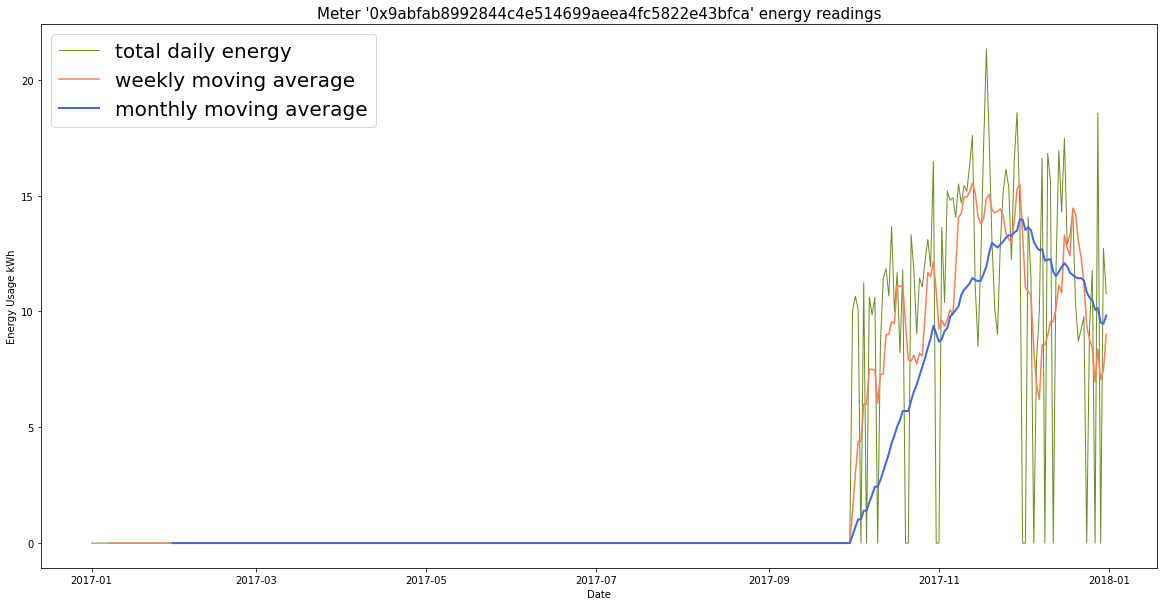

showing row:  1346


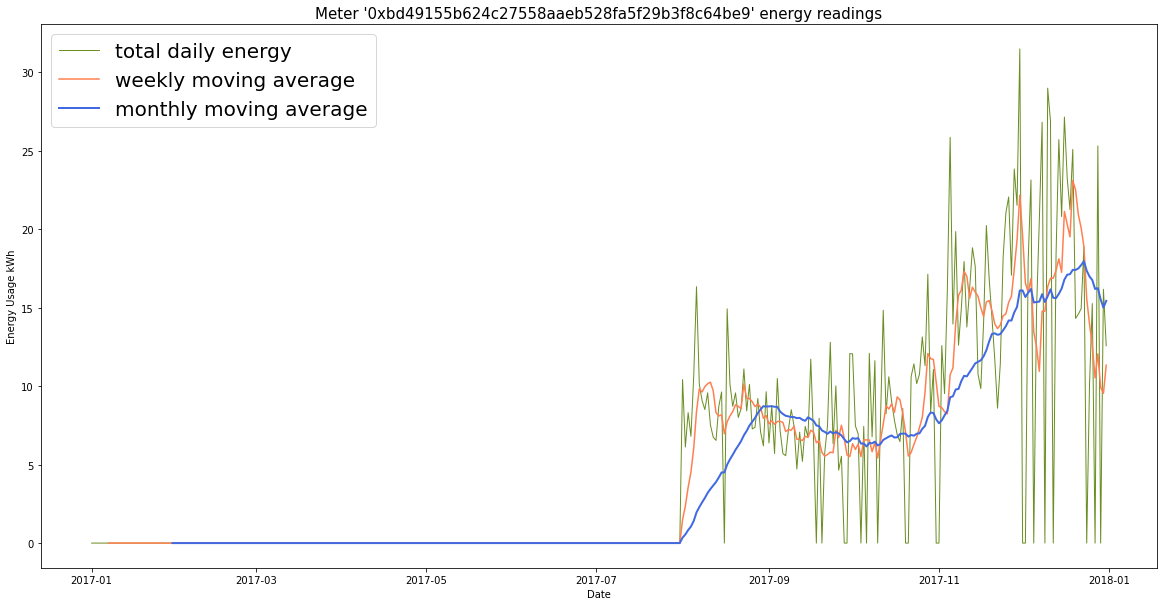

showing row:  1618


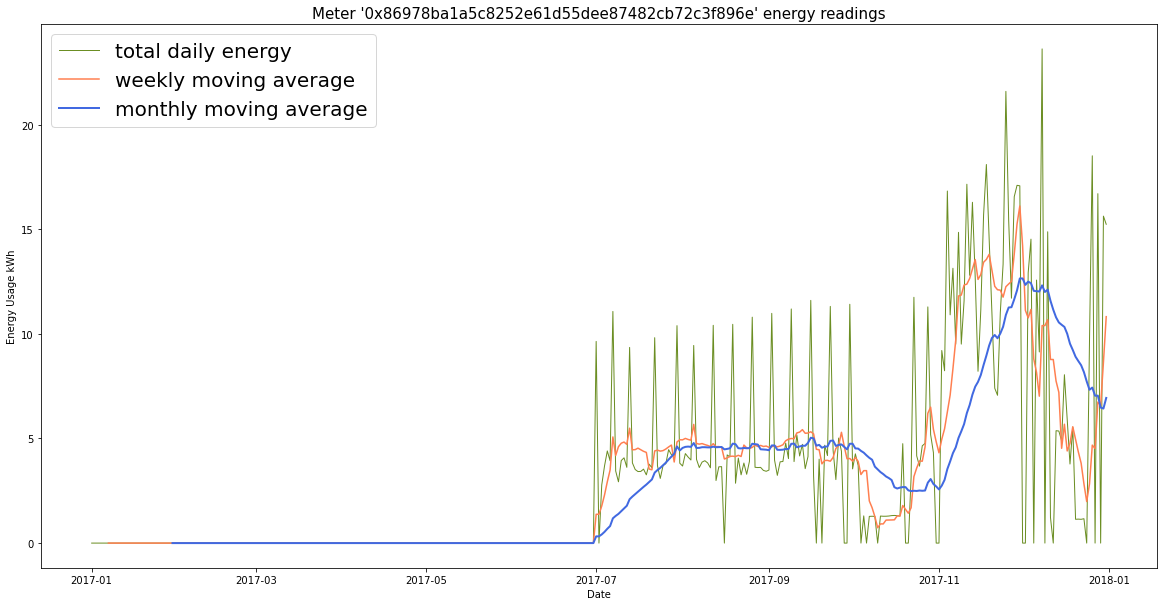

showing row:  2105


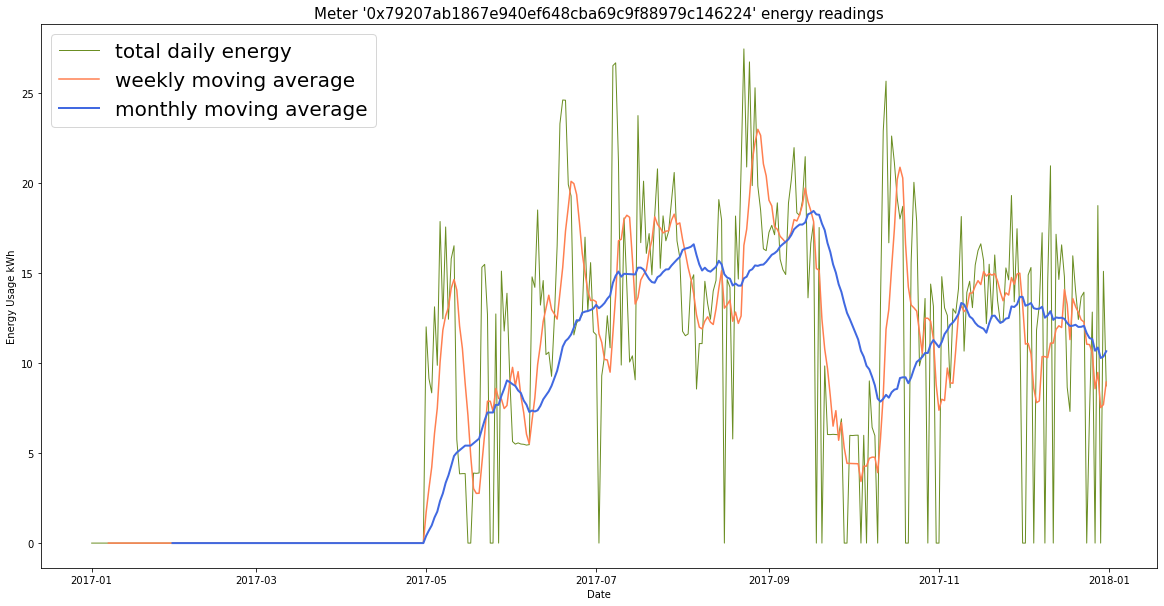

showing row:  3034


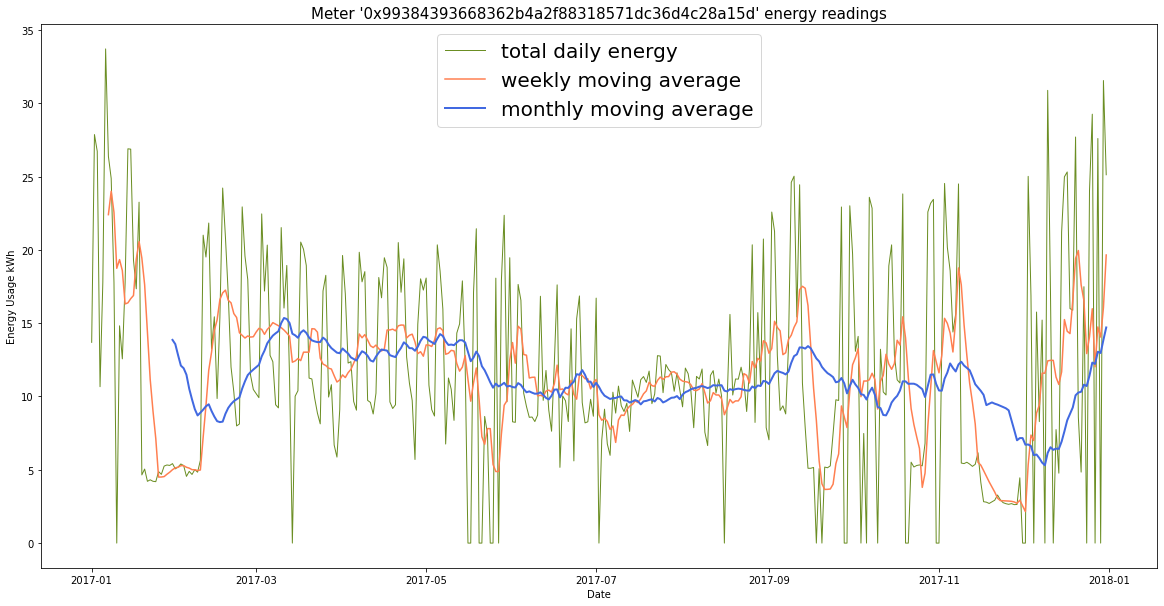

In [322]:
#plotting the uninterpolated data
plot_time_patterns(df_energy_daily, "", display_pid)

  0%|          | 0/3248 [00:00<?, ?it/s]

showing row:  651


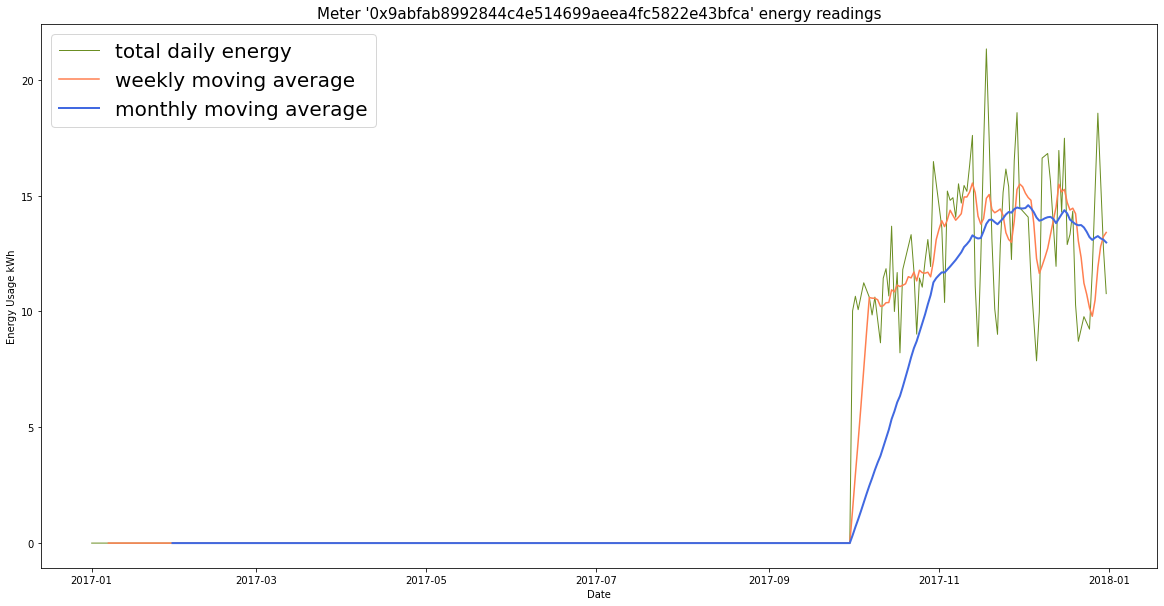

showing row:  1346


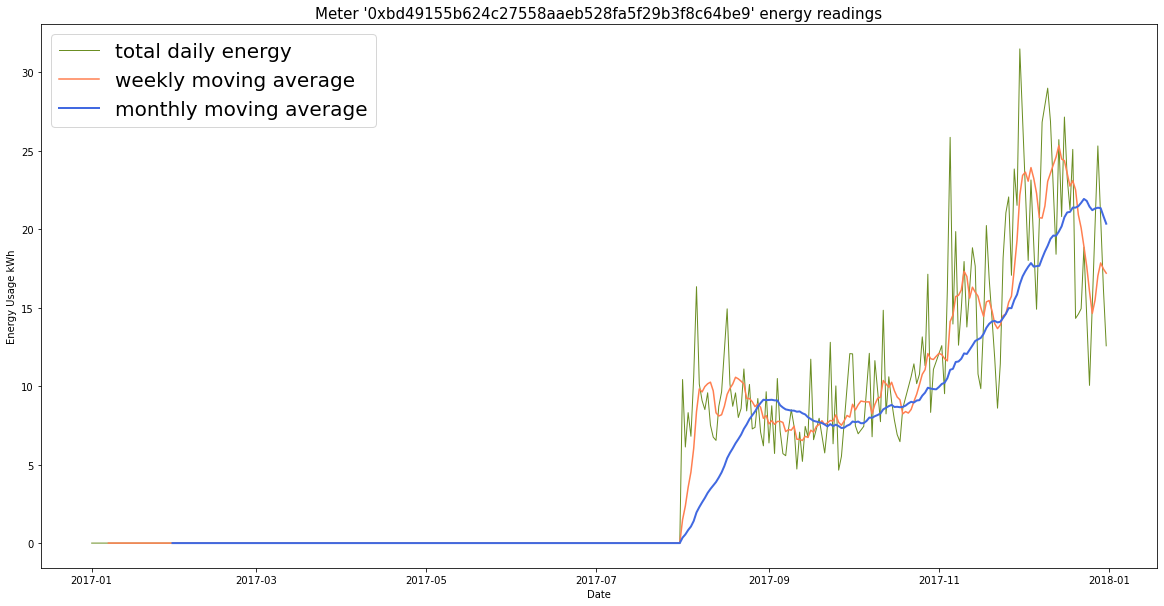

showing row:  1618


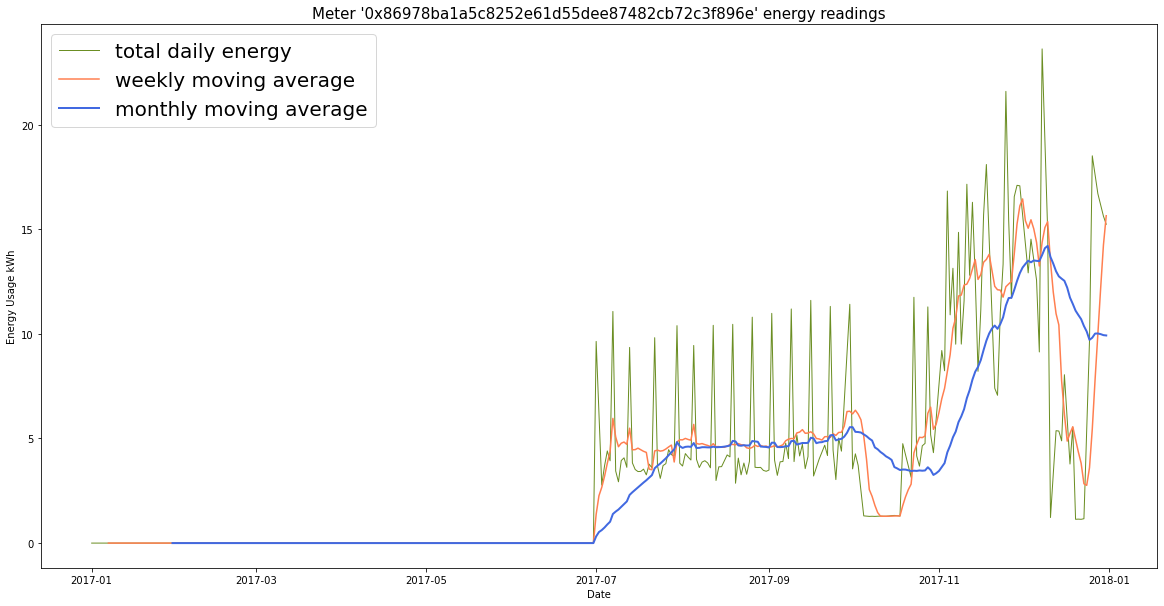

showing row:  2105


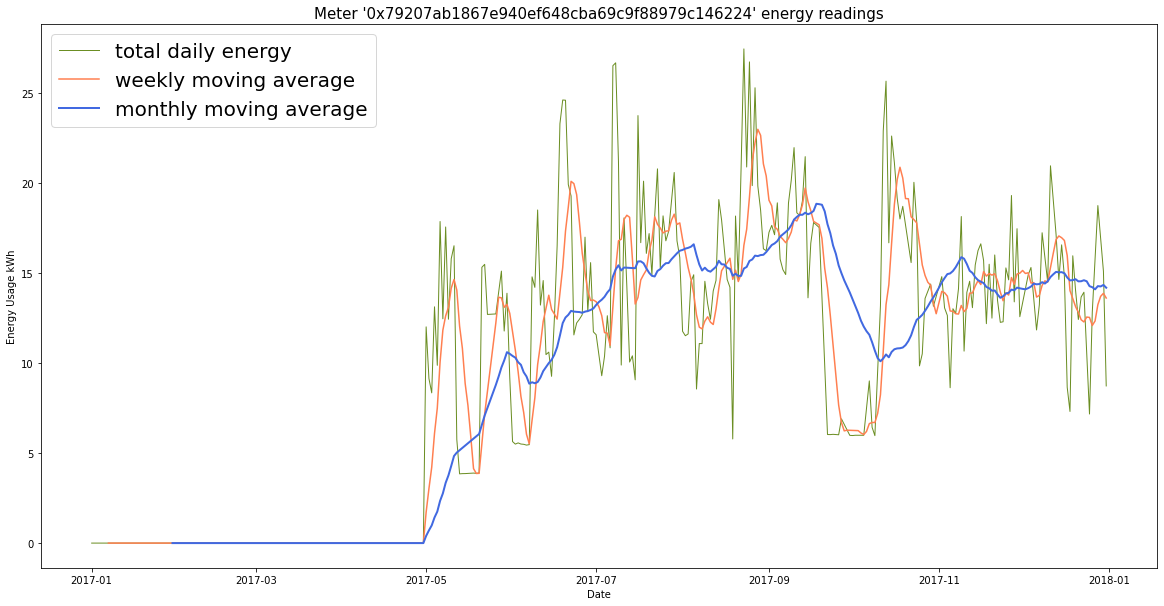

showing row:  3034


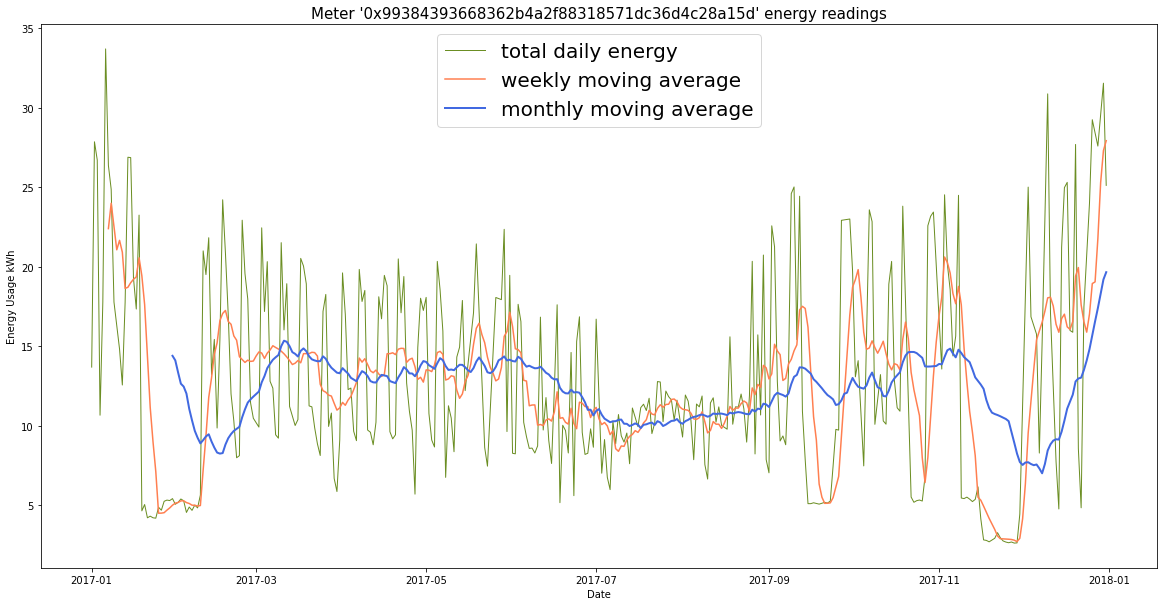

In [323]:
#plotting the interpolated data
plot_time_patterns(df_energy_interpolate.fillna(0), "interpolated/", display_pid)

## Calculating monthly averages (not sure if needed or not so commented out; may be worth using as another column after preparing data for time series?)

In [126]:
"""#resampling into months
df_energy_month = pd.DataFrame(columns=["meter_id"])
df_energy_month["meter_id"] = meter_id

#for each month in the range of dates
for month_i in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = "M")):
    #going to give column name middle of month temporarily for ease of plotting, then will remove
    middle_of_month = str(month_i.replace(day=1)+(month_i-month_i.replace(day=1))/2)
    
    #get this months name as a string
    monthName = str(month_i.date())[:7]
    #get all columns that relate to this months
    col_month_i = [i for i in df_energy_daily.columns.values[1:] if i.startswith(monthName)]
    #sum these up into a monthly value
    df_energy_month[middle_of_month] = df_energy_daily[col_month_i].mean(axis=1) # midway through month so easier to plot"""

'#resampling into months\ndf_energy_month = pd.DataFrame(columns=["meter_id"])\ndf_energy_month["meter_id"] = meter_id\n\n#for each month in the range of dates\nfor month_i in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = "M")):\n    #going to give column name middle of month temporarily for ease of plotting, then will remove\n    middle_of_month = str(month_i.replace(day=1)+(month_i-month_i.replace(day=1))/2)\n    \n    #get this months name as a string\n    monthName = str(month_i.date())[:7]\n    #get all columns that relate to this months\n    col_month_i = [i for i in df_energy_daily.columns.values[1:] if i.startswith(monthName)]\n    #sum these up into a monthly value\n    df_energy_month[middle_of_month] = df_energy_daily[col_month_i].mean(axis=1) # midway through month so easier to plot'

#### Conclusions:
* Have removed the missing values that could be removed via linear interpolation:
    * when there are values before and after the sequence of ?
* Still have lots of missing values at start and end of dataset

____________________________
____________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
____________________________________________________
____________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
____________________________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
____________________________________________________
____________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
__________________

# EDA on AddInfo
## Adding missing rows to AddInfo based on missing meter_id's

In [127]:
# first making both dataframes alphabetical in order of meter_id for ease of comparison
df_info.sort_values('meter_id')

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
750,0x000f697092696c27b0bb489ea4c11280ef72ab82,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0x001d6227832325ab6167b82d6d7175d254f57c3a,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,0x005958406351bb29580475df698b5f1070096397,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
694,0x00735e1aa83d97d9209cce47d8777b4ff3cc0554,terraced_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2056,0x0079fa6c2cbd3de97c8aa6073ff365b41ee087ab,terraced_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1685,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
df_energy.sort_values('meter_id')

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [129]:
#adding the missing meter rows to df_info
df_info_all_meters = pd.merge(df_info, df_energy["meter_id"], on="meter_id",how="outer")

In [130]:
#checking the values are correct now
df_info_all_meters.sort_values('meter_id')

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
2532,0x0001f1c389823f953b2eaee0a61c33539744da0c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,0x000f697092696c27b0bb489ea4c11280ef72ab82,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2468,0x0019979ee12c59accd24d1c83291528ced1bb734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0x001d6227832325ab6167b82d6d7175d254f57c3a,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,0x005958406351bb29580475df698b5f1070096397,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1685,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
#checking the shape is correct now
df_info_all_meters.shape

(3248, 24)

## Exploring datatypes and unique values

In [132]:
# inspecting the types of each column
df_info_all_meters.dtypes

meter_id                          object
dwelling_type                     object
num_occupants                    float64
num_bedrooms                     float64
heating_fuel                      object
hot_water_fuel                    object
boiler_age                        object
loft_insulation                   object
wall_insulation                   object
heating_temperature               object
efficient_lighting_percentage     object
dishwasher                       float64
freezer                          float64
fridge_freezer                   float64
refrigerator                     float64
tumble_dryer                     float64
washing_machine                  float64
game_console                     float64
laptop                           float64
pc                               float64
router                           float64
set_top_box                      float64
tablet                           float64
tv                               float64
dtype: object

In [133]:
#looking at the unique values for each column
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    print(column+" unique value count: "+str(df_info_all_meters[column].nunique()))
    print(df_info_all_meters[column].unique())
    print()

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' nan 'bungalow'
 'flat']

num_occupants unique value count: 4
[nan  2.  4.  3.  1.]

num_bedrooms unique value count: 5
[ 3.  2. nan  4.  5.  1.]

heating_fuel unique value count: 4
[nan 'gas' 'elec' 'other' 'lpg_oil']

hot_water_fuel unique value count: 3
[nan 'gas' 'elec' 'other']

boiler_age unique value count: 2
[nan 'new' 'old']

loft_insulation unique value count: 2
[nan 'y' 'n']

wall_insulation unique value count: 5
[nan 'y_cavity' 'n' 'y_internal' 'not_sure' 'y_external']

heating_temperature unique value count: 4
[nan '18_to_20' 'above_20' 'below_18' 'not_sure']

efficient_lighting_percentage unique value count: 4
[nan '0_to_25' '25_to_50' '50_to_75' '75_to_100']

dishwasher unique value count: 3
[nan  1.  0.  2.]

freezer unique value count: 3
[nan  2.  1.  0.]

fridge_freezer unique value count: 3
[nan  2.  0.  1.]

refrigerator unique value count: 3
[nan  2.  1.  0.]

tumble_dryer u

* We now know:
    1. The columns that contain categorical values vs the columns that contain real numbers
    2. The unique values for each column
    
## Exploring missing values
### Visualising as histogram

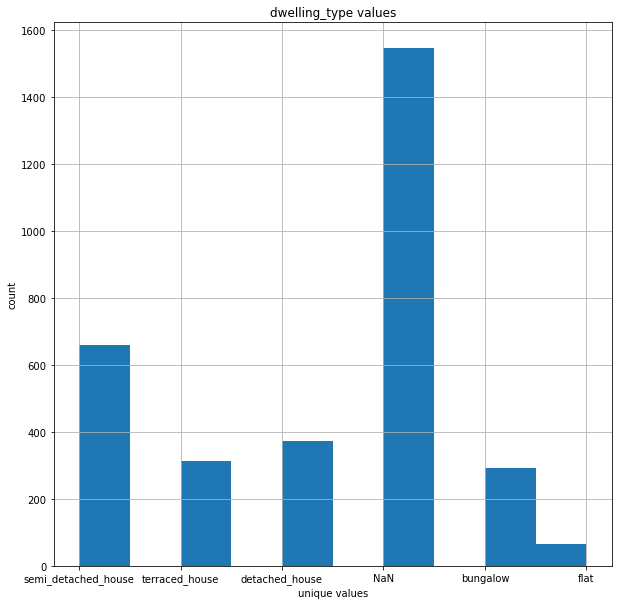

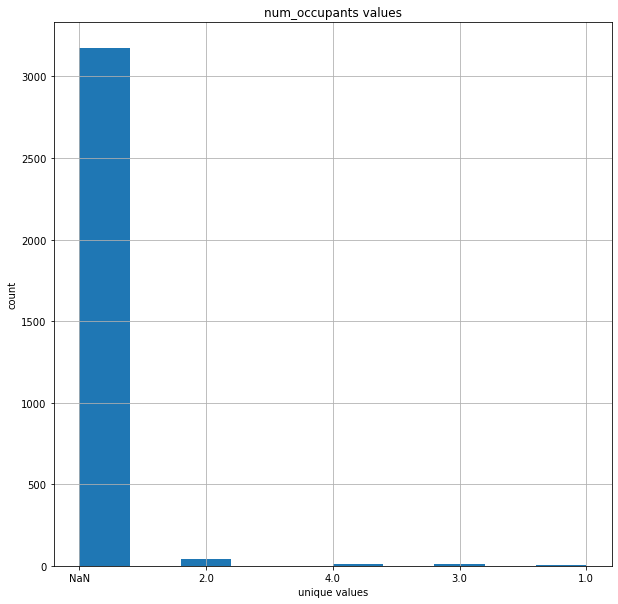

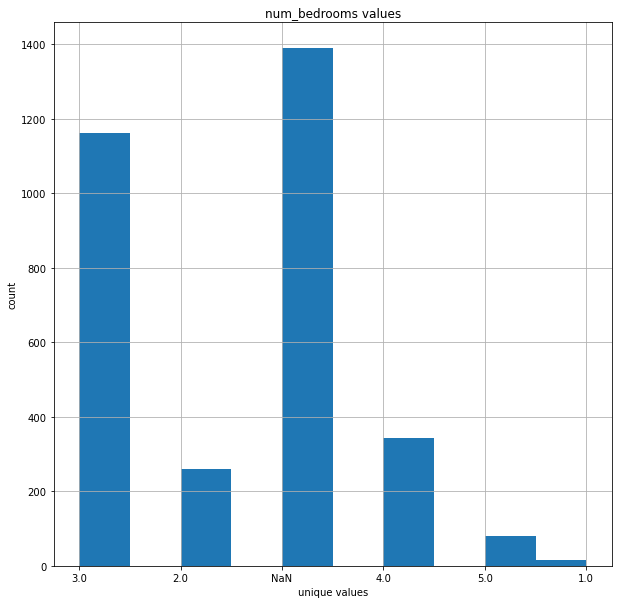

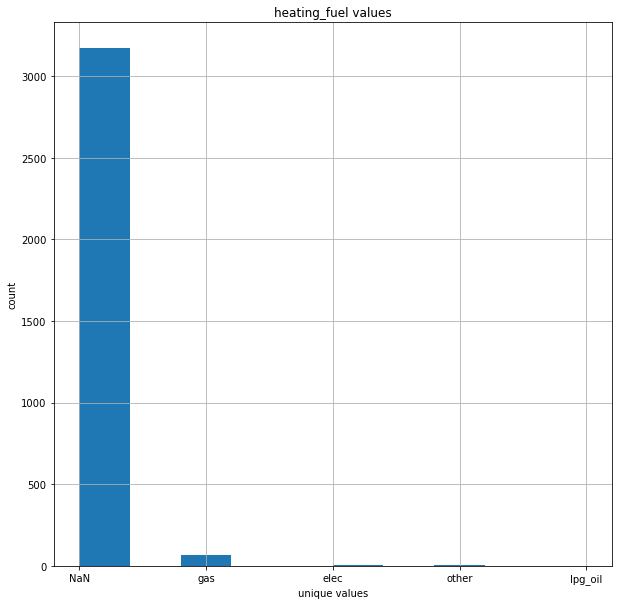

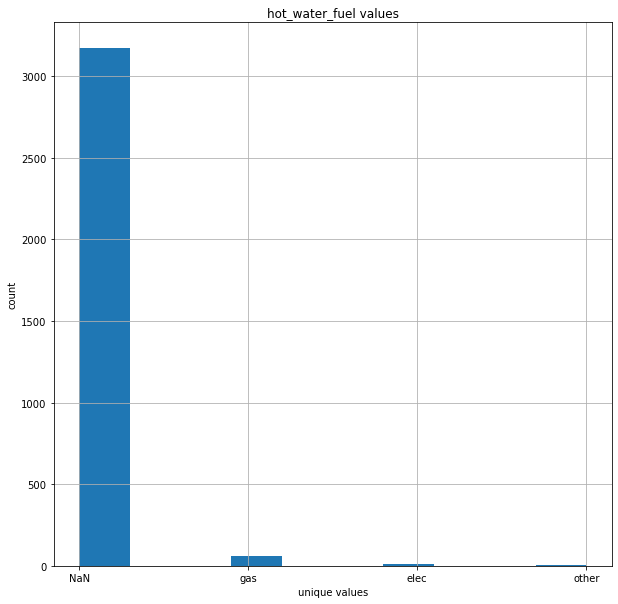

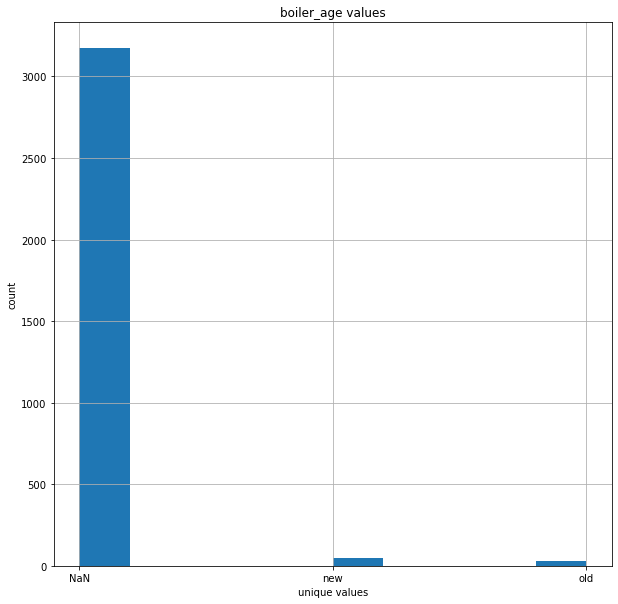

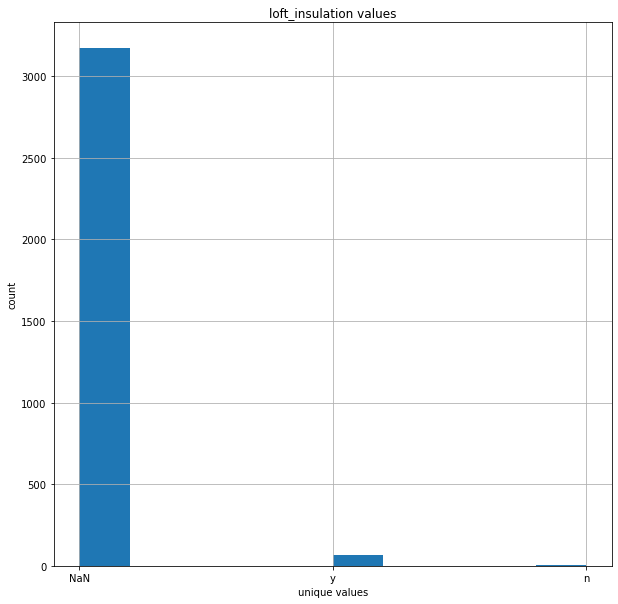

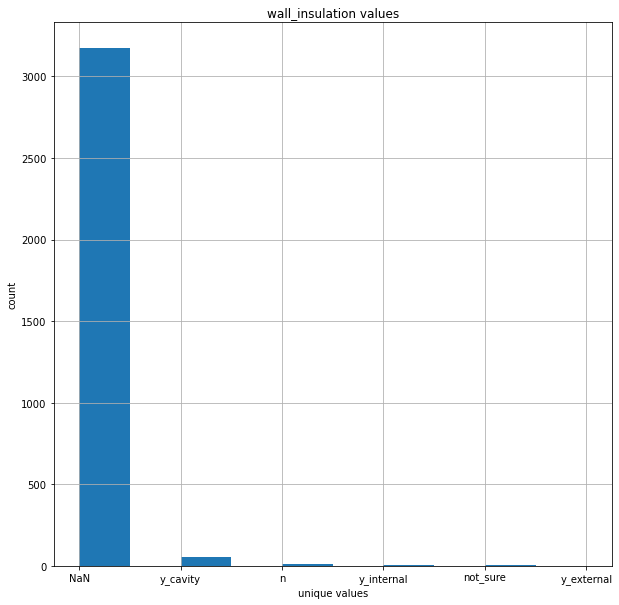

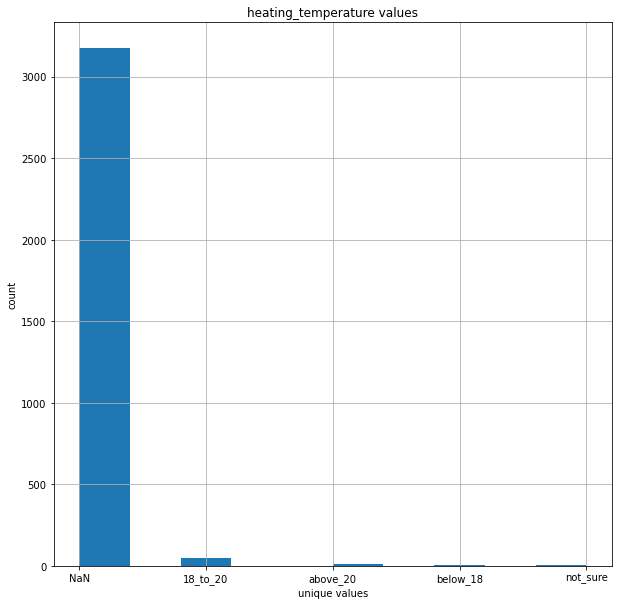

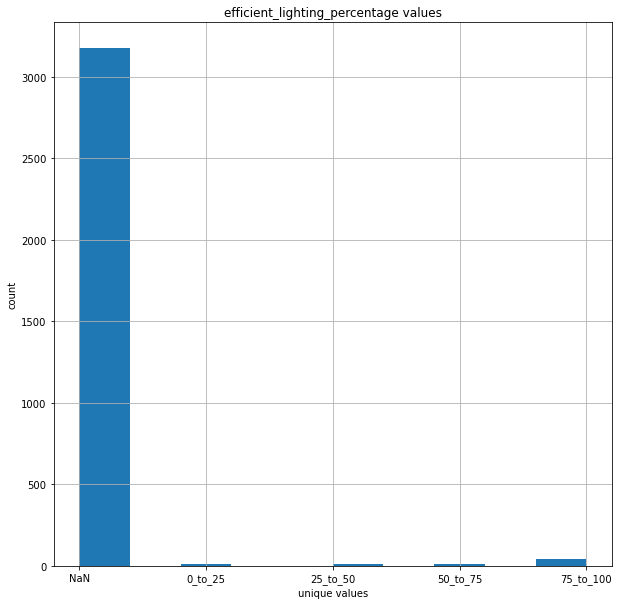

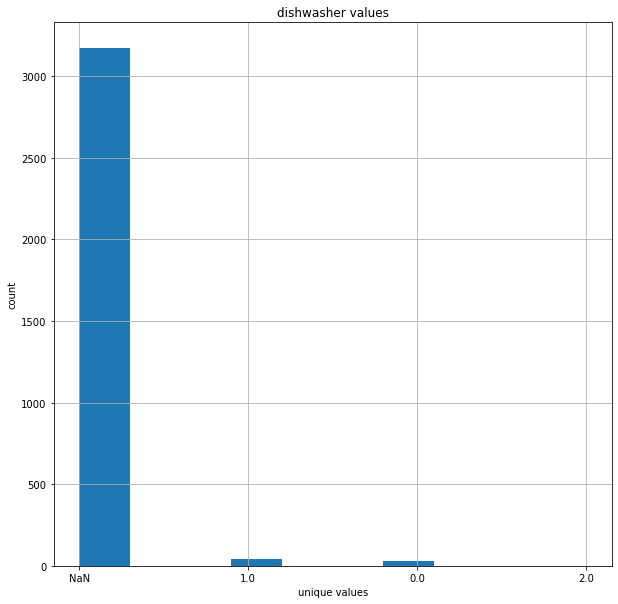

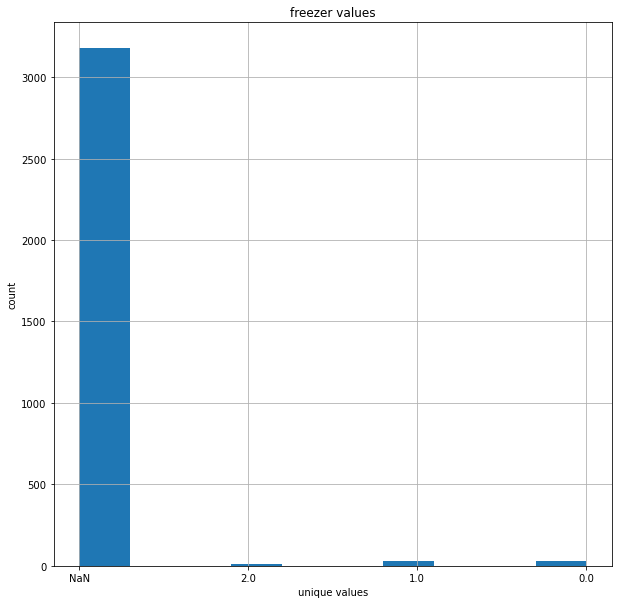

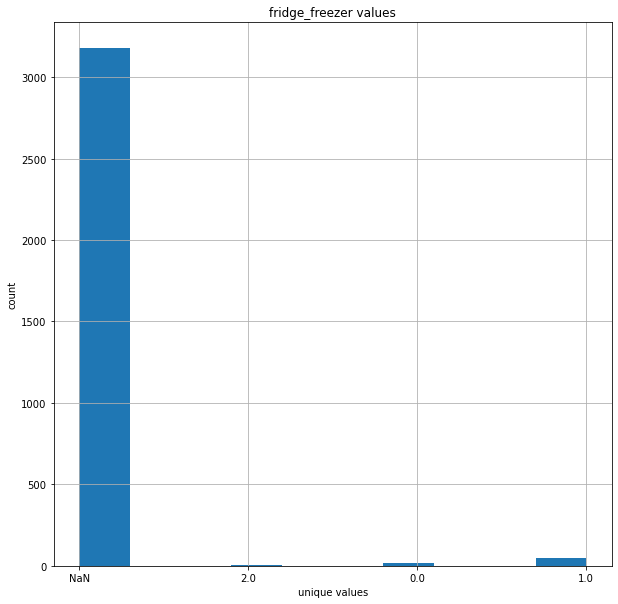

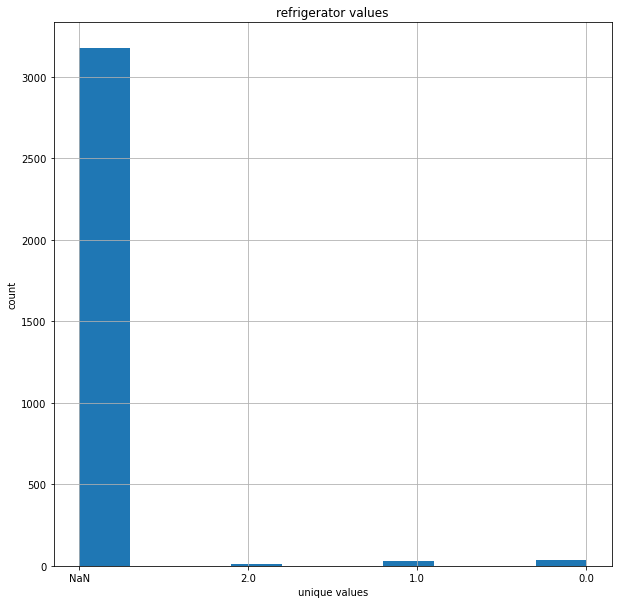

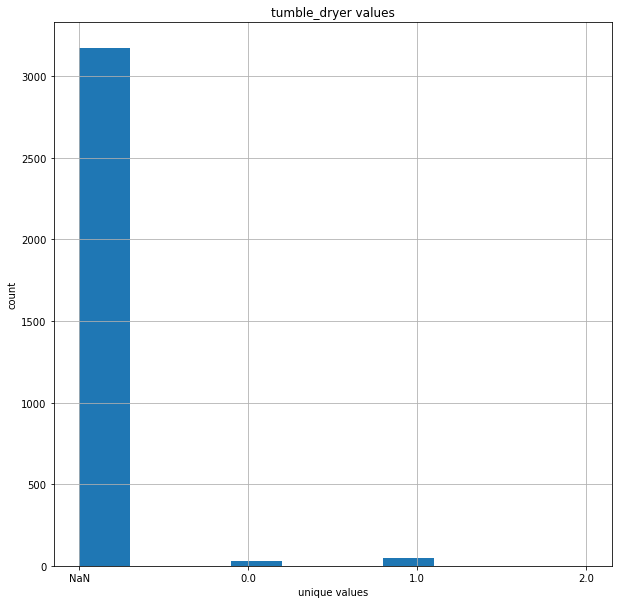

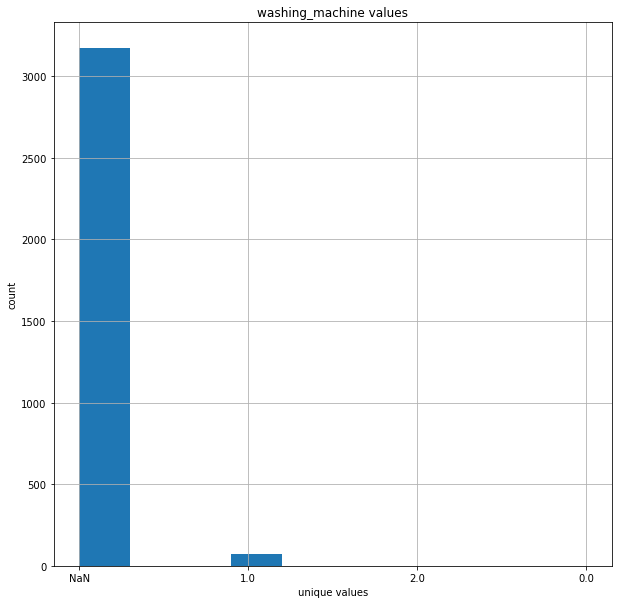

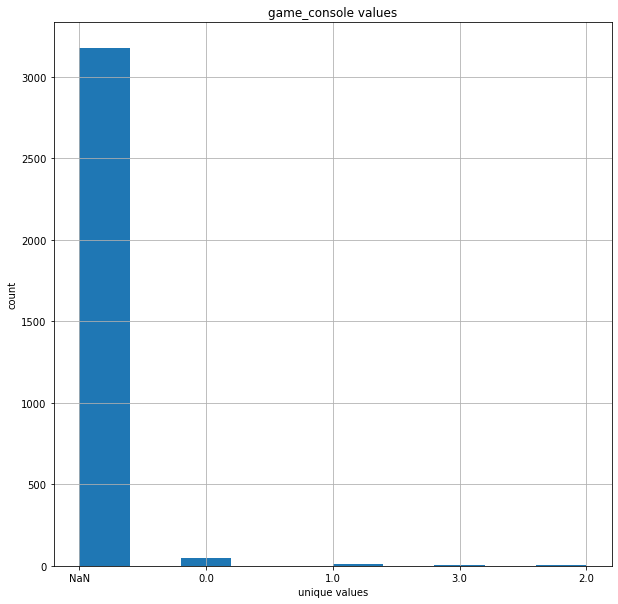

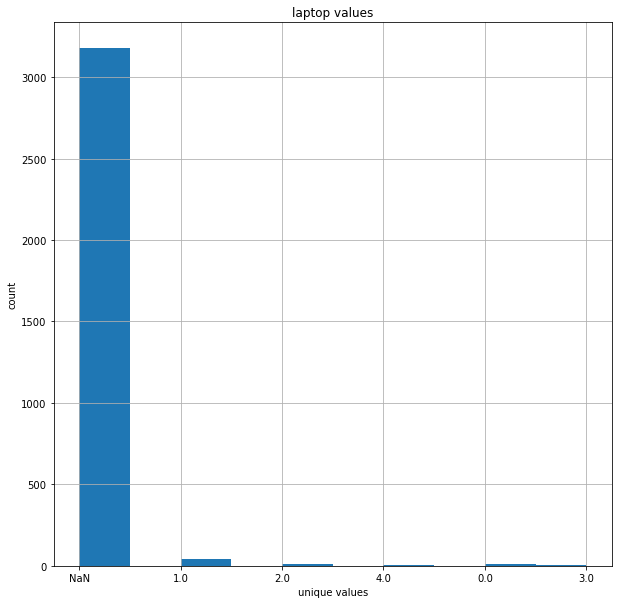

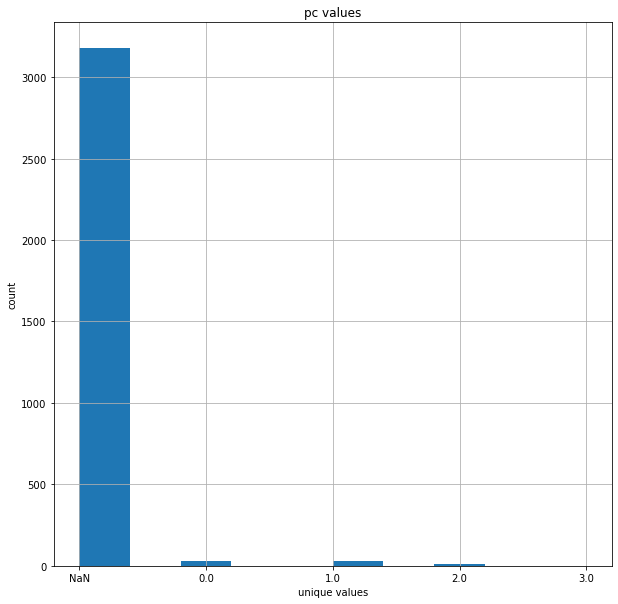

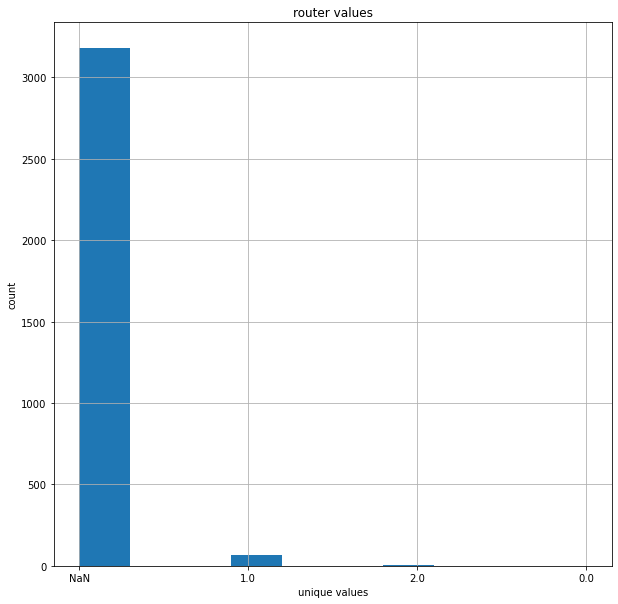

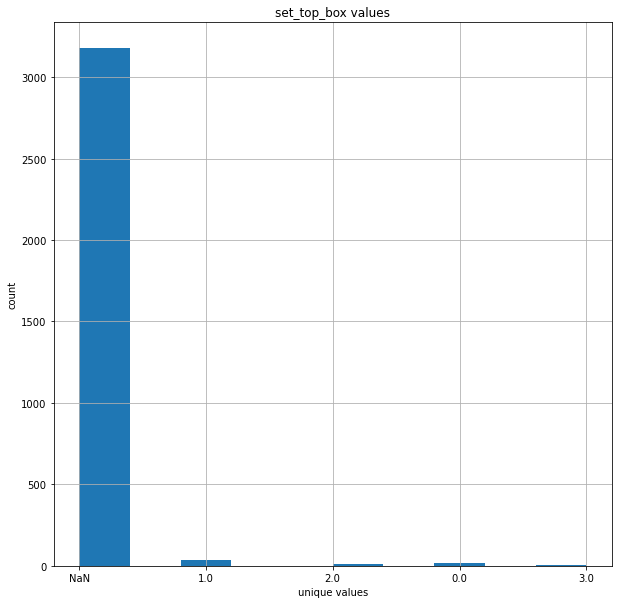

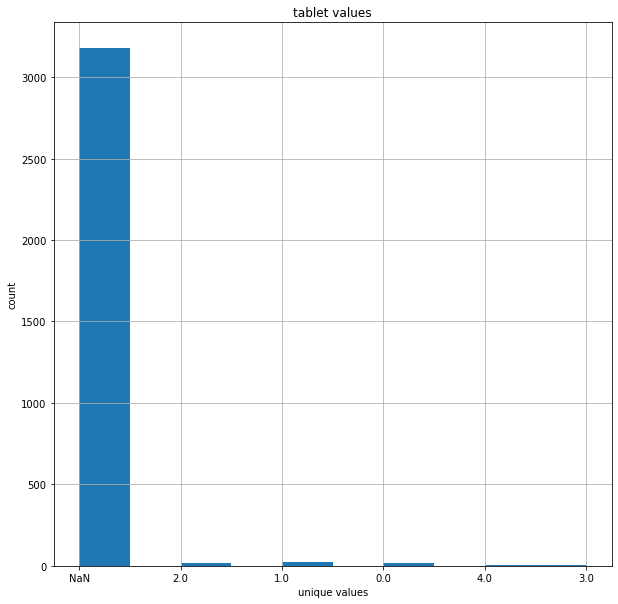

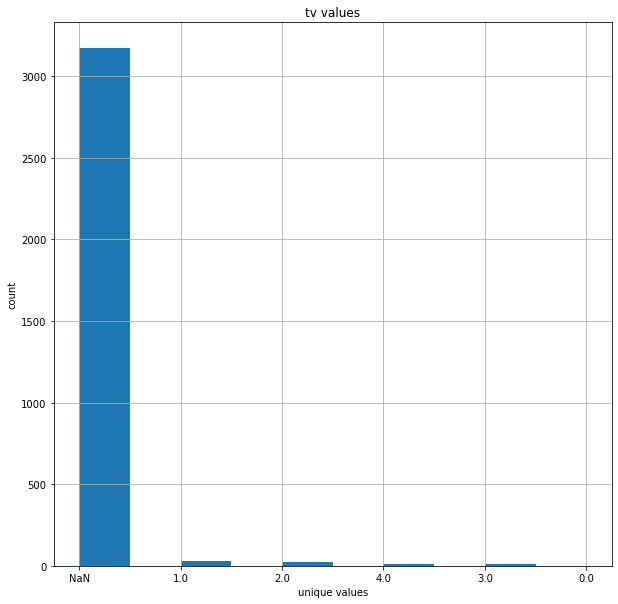

In [134]:
# plotting a histogram for each of the columns in the dataset
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column].replace(np.nan,"NaN").apply(str)
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/{column}_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/{column}_hist.png")
        
    plt.close(fig)

### Calculating percentage of missing values for each column

In [135]:
# Calculating percentage of missing values
#stores index of columns to keep: defaults all to true and will check which to make false
columns = np.full((df_info_all_meters.shape[1],), True, dtype=bool)

# getting the count of each object type in each column
for i in range(0,len(df_info_all_meters.columns)):
    column =df_info_all_meters.columns[i]
    #calculating the percentage of missing values
    percent_missing = df_info_all_meters[column].isnull().sum() * 100 / len(df_info_all_meters)
    print(column+" contains missing values: "+str(df_info_all_meters[column].isna().values.any()))
    print(column+" is missing: "+str(round(percent_missing,2))+"%")
    
    #if the percentage of missing values is greater than 50% mark them to be removed
    if(percent_missing>=50):
        print("Marked ",column,"for removal due to it having more than 50% missing values")
        columns[i] = False
    else:
        print("Not marked ",column,"for removal due to it not having more than 50% missing values")
    print()

meter_id contains missing values: False
meter_id is missing: 0.0%
Not marked  meter_id for removal due to it not having more than 50% missing values

dwelling_type contains missing values: True
dwelling_type is missing: 47.6%
Not marked  dwelling_type for removal due to it not having more than 50% missing values

num_occupants contains missing values: True
num_occupants is missing: 97.72%
Marked  num_occupants for removal due to it having more than 50% missing values

num_bedrooms contains missing values: True
num_bedrooms is missing: 42.76%
Not marked  num_bedrooms for removal due to it not having more than 50% missing values

heating_fuel contains missing values: True
heating_fuel is missing: 97.6%
Marked  heating_fuel for removal due to it having more than 50% missing values

hot_water_fuel contains missing values: True
hot_water_fuel is missing: 97.66%
Marked  hot_water_fuel for removal due to it having more than 50% missing values

boiler_age contains missing values: True
boiler_a

#### Meaning of findings;
* As the histograms and calculations show: there is a massive amount of missing values
* Marked all columns with > 50% missing values for removal
    * as if more than half of the values are missing it is likely what we do impute won't be accurate
* Need to decide what to do with the the remaining 2 as they have 40% missing values: is this good enough?
    * Will likely require experimentation:
        * So will run one model which only uses energy
        * And one that uses addInfo after the missing values have been imputed

## Removing the columns with greater than 50% missing values

In [136]:
# Removing the columns marked for removal
selected_columns = df_info_all_meters.columns[columns]
df_info_all_meters = df_info_all_meters[selected_columns]

In [137]:
# inspecting the current state of df_info_all_meters
df_info_all_meters

,meter_id,dwelling_type,num_bedrooms
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,3.0
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,2.0
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,4.0
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN
...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,NaN,NaN
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,NaN,NaN
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,NaN,NaN
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,NaN,NaN


## Imputing the missing values
* May be worth experimenting with different imputation methods
* But for now just going with KNN

### Preparing dataframe for use by KNNImputer
### Adding information on the energy time series data that may be useful for imputing the missing addInfo values
Experimenting with different combinations 9think it may have been too many when I originally used 4 different energy ones and it got weighted too highly skewing it due to the multi collinearity problems

In [138]:
# Calculating the total, mean, max, and min energy usage only using KNOWN values (not including the interpolated ones)
df_energy_info = pd.DataFrame(columns=["meter_id",
                                       "mean_energy_usage",
                                       #"max_energy_usage",
                                       #"min_energy_usage",
                                       "total_energy_usage"
                                      ])
df_energy_info["meter_id"]=df_energy_daily["meter_id"].values
df_energy_info["mean_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].mean(axis=1).round(3)
#df_energy_info["max_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].max(axis=1).round(3)
#df_energy_info["min_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].min(axis=1).round(3)
df_energy_info["total_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].sum(axis=1).round(3)

In [139]:
df_energy_info#.loc[df_energy_means["meter_id"]=="0xa62b9f23553ff183f61e2bf943aab3d5983d02d7"]

,meter_id,mean_energy_usage,total_energy_usage
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,4.413,101.490
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.888,434.419
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,12.482,287.095
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,18.237,419.449
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,32.586,749.479
...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,5.200,1747.050
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,5.930,1867.938
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,5.755,1939.346
3246,0x47218b46abb2fcaade487a211911406dc6e13730,15.129,5113.478


In [140]:
#add the total, mean, max, and min to the df for use with knn imputation
df_info_knn = df_info_all_meters
df_info_knn = df_info_knn.merge(df_energy_info[["meter_id",
                                                "mean_energy_usage",
                                                #"max_energy_usage",
                                                #"min_energy_usage", 
                                                "total_energy_usage"
                                               ]], on="meter_id",how="left")
df_info_knn#.loc[df_info_knn2["meter_id"]=="0xa62b9f23553ff183f61e2bf943aab3d5983d02d7"]

,meter_id,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,3.0,7.374,567.798
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,2.0,5.536,1062.901
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN,5.729,1105.627
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,4.0,10.597,551.037
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN,14.302,743.699
...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,NaN,NaN,21.294,7218.808
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,NaN,NaN,17.709,5932.525
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,NaN,NaN,11.912,4014.327
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,NaN,NaN,5.200,1747.050


### Dropping meter_id, encoding and normalizing data so it is suitable for KNN Imputation
#### Dropping meter_id

In [141]:
#dropping the id column so it doesn't negatively influence the knn algorithm
meter_id = df_info_knn["meter_id"]
df_info_knn = df_info_knn.drop(["meter_id"], axis=1)

In [142]:
#inspecting the df without the id column
df_info_knn

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,semi_detached_house,3.0,7.374,567.798
1,terraced_house,2.0,5.536,1062.901
2,semi_detached_house,NaN,5.729,1105.627
3,detached_house,4.0,10.597,551.037
4,NaN,NaN,14.302,743.699
...,...,...,...,...
3243,NaN,NaN,21.294,7218.808
3244,NaN,NaN,17.709,5932.525
3245,NaN,NaN,11.912,4014.327
3246,NaN,NaN,5.200,1747.050


#### Encoding the categorical values ready for knn

In [143]:
df_info_knn_encoded = df_info_knn
df_info_knn_encoded["dwelling_type"]=df_info_knn_encoded["dwelling_type"].replace("flat",0).replace("terraced_house",1).replace("semi_detached_house",2).replace("detached_house",3).replace("bungalow",4)

"""df_dwelling_types_encoded = df_info_knn["dwelling_type"]
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("flat",0)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("terraced_house",1)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("semi_detached_house",2)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("detached_house",3)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("bungalow",4)"""

'df_dwelling_types_encoded = df_info_knn["dwelling_type"]\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("flat",0)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("terraced_house",1)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("semi_detached_house",2)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("detached_house",3)\ndf_dwelling_types_encoded=df_dwelling_types_encoded.replace("bungalow",4)'

In [144]:
df_info_knn_encoded

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,2.0,3.0,7.374,567.798
1,1.0,2.0,5.536,1062.901
2,2.0,NaN,5.729,1105.627
3,3.0,4.0,10.597,551.037
4,NaN,NaN,14.302,743.699
...,...,...,...,...
3243,NaN,NaN,21.294,7218.808
3244,NaN,NaN,17.709,5932.525
3245,NaN,NaN,11.912,4014.327
3246,NaN,NaN,5.200,1747.050


#### Normalizing the data

In [145]:
# Normalizing the data as KNN is done via a distance measure and we don't want to skew it
scaler = MinMaxScaler()
df_info_knn_normalized = pd.DataFrame(scaler.fit_transform(df_info_knn_encoded), columns = df_info_knn_encoded.columns)

# inspecting new state of the dataframe after normalisation
df_info_knn_normalized

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,0.50,0.50,0.102095,0.034547
1,0.25,0.25,0.076361,0.064671
2,0.50,NaN,0.079063,0.067271
3,0.75,0.75,0.147219,0.033527
4,NaN,NaN,0.199093,0.045250
...,...,...,...,...
3243,NaN,NaN,0.296987,0.439221
3244,NaN,NaN,0.246794,0.360959
3245,NaN,NaN,0.165631,0.244248
3246,NaN,NaN,0.071657,0.106298


### Now data is prepared, using KNN to impute the missing values
* Experiment with different numbers for nearest neighbours

In [146]:
# now using KNN to impute the missing values
imputer = KNNImputer(n_neighbors=5)
df_info_knn_imputed = pd.DataFrame(imputer.fit_transform(df_info_knn_normalized),columns = df_info_knn_normalized.columns)

# inspecting new state of the dataset now it no longer has missing values
df_info_knn_imputed

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,0.50,0.50,0.102095,0.034547
1,0.25,0.25,0.076361,0.064671
2,0.50,0.45,0.079063,0.067271
3,0.75,0.75,0.147219,0.033527
4,0.65,0.70,0.199093,0.045250
...,...,...,...,...
3243,0.40,0.65,0.296987,0.439221
3244,0.60,0.55,0.246794,0.360959
3245,0.75,0.55,0.165631,0.244248
3246,0.60,0.45,0.071657,0.106298


In [147]:
# checking it no longer has missing values
df_info_knn_imputed.isna().any()

dwelling_type         False
num_bedrooms          False
mean_energy_usage     False
total_energy_usage    False
dtype: bool

In [148]:
# looking at sum of missing values
df_info_knn_imputed.isna().sum()

dwelling_type         0
num_bedrooms          0
mean_energy_usage     0
total_energy_usage    0
dtype: int64

#### Turning these imputed values to usable values

In [149]:
#Unnormalsing the data
df_info_knn_imputed.columns[1:] #ignoring meter id as that wasn't normalized
df_info_knn_finished = pd.DataFrame(scaler.inverse_transform(df_info_knn_imputed), columns = df_info_knn_imputed.columns) # reversing the normalization

In [150]:
# viewing the unormalised data
df_info_knn_finished

,dwelling_type,num_bedrooms,mean_energy_usage,total_energy_usage
0,2.0,3.0,7.374,567.798
1,1.0,2.0,5.536,1062.901
2,2.0,2.8,5.729,1105.627
3,3.0,4.0,10.597,551.037
4,2.6,3.8,14.302,743.699
...,...,...,...,...
3243,1.6,3.6,21.294,7218.808
3244,2.4,3.2,17.709,5932.525
3245,3.0,3.2,11.912,4014.327
3246,2.4,2.8,5.200,1747.050


In [151]:
#rounding bedrooms to their final value
num_bedrooms=df_info_knn_finished["num_bedrooms"].round() 

In [152]:
#rounding dwelling type to a real value
df_dwellings=df_info_knn_finished["dwelling_type"].round() 
#reverting the encoding
df_dwellings=df_dwellings.replace(0, "flat").replace(1, "terraced_house").replace(2, "semi_detached_house").replace(3, "detached_house").replace(4, "bungalow")


In [153]:
#concatenating the meter_id, number of bedrooms, and dwellings columns
df_info_knn_finished = pd.concat([meter_id, num_bedrooms, df_dwellings], axis=1)

In [154]:
#inspecting the final configuration of the knn imputed values
df_info_knn_finished

,meter_id,num_bedrooms,dwelling_type
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,3.0,semi_detached_house
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,2.0,terraced_house
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,3.0,semi_detached_house
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,4.0,detached_house
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,4.0,detached_house
...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,4.0,semi_detached_house
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,3.0,semi_detached_house
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,3.0,detached_house
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,3.0,semi_detached_house


## Checking the unique values are the same as the original set

In [155]:
#looking at the unique values for each column before imputation
print("Unique values before imputation")

print("num_bedrooms unique value count: "+str(df_info_all_meters["num_bedrooms"].nunique()))
print(df_info_all_meters["num_bedrooms"].unique())
print()
print("dwelling_type unique value count: "+str(df_info_all_meters["dwelling_type"].nunique()))
print(df_info_all_meters["dwelling_type"].unique())
print()

Unique values before imputation
num_bedrooms unique value count: 5
[ 3.  2. nan  4.  5.  1.]

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' nan 'bungalow'
 'flat']



In [156]:
#looking at the unique values for each column before imputation
print("Unique values after imputation\n")

print("num_bedrooms unique value count: "+str(df_info_knn_finished["num_bedrooms"].nunique()))
print(df_info_knn_finished["num_bedrooms"].unique())
print()
print("dwelling_type unique value count: "+str(df_info_knn_finished["dwelling_type"].nunique()))
print(df_info_knn_finished["dwelling_type"].unique())
print()

Unique values after imputation

num_bedrooms unique value count: 5
[3. 2. 4. 5. 1.]

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' 'bungalow' 'flat']



## Comparing the distribution of unique values that were distributed to the original

In [157]:
#looking at percentage distribution of values before imputation
print("Distribution of unique values before imputation")
print()

num_bedrooms_percentages = df_info_all_meters['num_bedrooms'].value_counts(normalize=True) * 100
print("num_bedrooms percentages")
print(num_bedrooms_percentages)
print()
print("num_bedrooms totals")
print(df_info_all_meters['num_bedrooms'].value_counts())
print()
print()

dwelling_type_percentages = df_info_all_meters['dwelling_type'].value_counts(normalize=True) * 100
print("dwelling_type percentages")
print(dwelling_type_percentages)
print()
print("dwelling_type totals")
print(df_info_all_meters['dwelling_type'].value_counts())

Distribution of unique values before imputation

num_bedrooms percentages
3.0    62.506724
4.0    18.396988
2.0    14.039806
5.0     4.249597
1.0     0.806885
Name: num_bedrooms, dtype: float64

num_bedrooms totals
3.0    1162
4.0     342
2.0     261
5.0      79
1.0      15
Name: num_bedrooms, dtype: int64


dwelling_type percentages
semi_detached_house    38.719154
detached_house         21.974148
terraced_house         18.331375
bungalow               17.215041
flat                    3.760282
Name: dwelling_type, dtype: float64

dwelling_type totals
semi_detached_house    659
detached_house         374
terraced_house         312
bungalow               293
flat                    64
Name: dwelling_type, dtype: int64


In [158]:
#looking at percentage distribution of values after imputation
print("Distribution of unique values before imputation")
print()

num_bedrooms_percentages = df_info_knn_finished['num_bedrooms'].value_counts(normalize=True) * 100
print("num_bedrooms percentages")
print(num_bedrooms_percentages)
print()
print("num_bedrooms totals")
print(df_info_knn_finished['num_bedrooms'].value_counts())
print()
print()

dwelling_type_percentages = df_info_knn_finished['dwelling_type'].value_counts(normalize=True) * 100
print("dwelling_type percentages")
print(dwelling_type_percentages)
print()
print("dwelling_type totals")
print(df_info_knn_finished['dwelling_type'].value_counts())
print()

Distribution of unique values before imputation

num_bedrooms percentages
3.0    70.966749
4.0    16.071429
2.0    10.067734
5.0     2.432266
1.0     0.461823
Name: num_bedrooms, dtype: float64

num_bedrooms totals
3.0    2305
4.0     522
2.0     327
5.0      79
1.0      15
Name: num_bedrooms, dtype: int64


dwelling_type percentages
semi_detached_house    51.139163
detached_house         25.738916
terraced_house         11.730296
bungalow                9.421182
flat                    1.970443
Name: dwelling_type, dtype: float64

dwelling_type totals
semi_detached_house    1661
detached_house          836
terraced_house          381
bungalow                306
flat                     64
Name: dwelling_type, dtype: int64



##### Conclusions:
* Hasn't imputed any meters to be a flat
* Hasn't imputed any meters to have 1 or 5 bedrooms
* Has essentially increased the % divide
    * Higher % represented classes were more likely to be picked
    * Whilst lower % represented classes were less likely to be picked 
* Expected behaviour but is this useful and has it imputed correctly?
* As mentioned already will experiment and see if using these meters or not improves performance more
    * From this we can infer if this was effective or not

## Plotting hists of the imputed addInfo
plotting hists of the imputed addInfo columns before and after imputation to compare their patterns

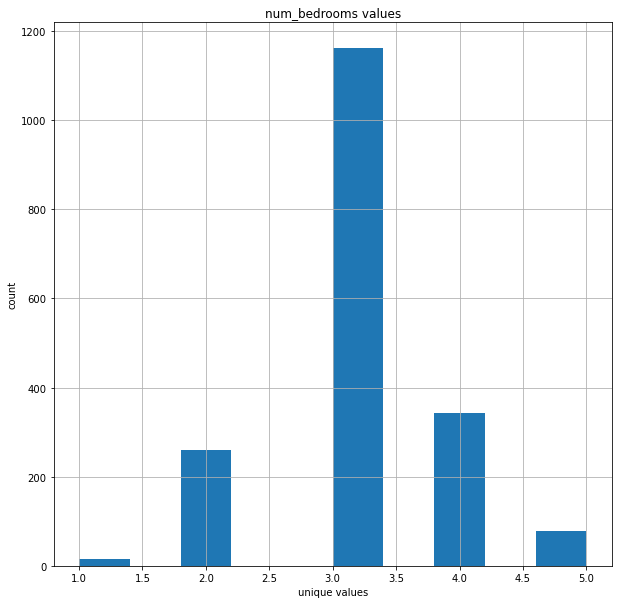

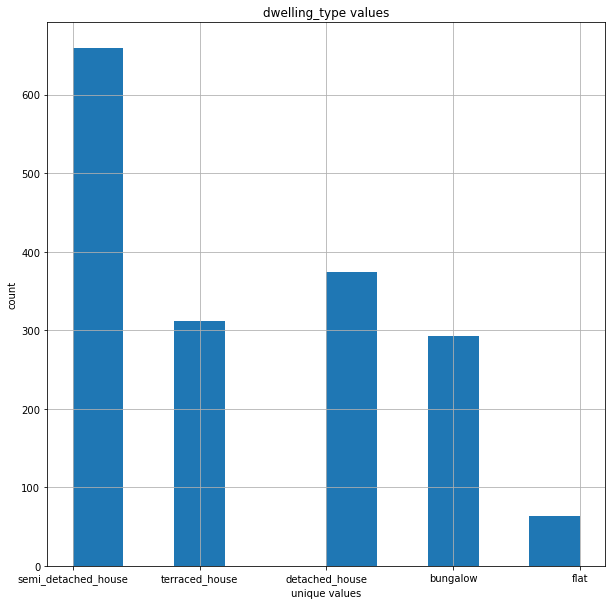

In [159]:
# plotting a histogram for each of the imputed columns in the dataset before imputation
for column in df_info_knn_finished.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column]
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/Pre-Imputation/{column}_preimp_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/Pre-Imputation/{column}_preimp_hist.png")
        
    plt.close(fig)

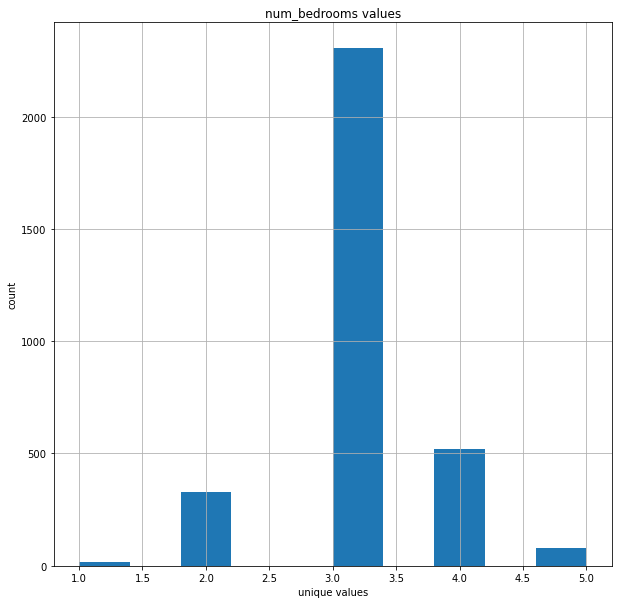

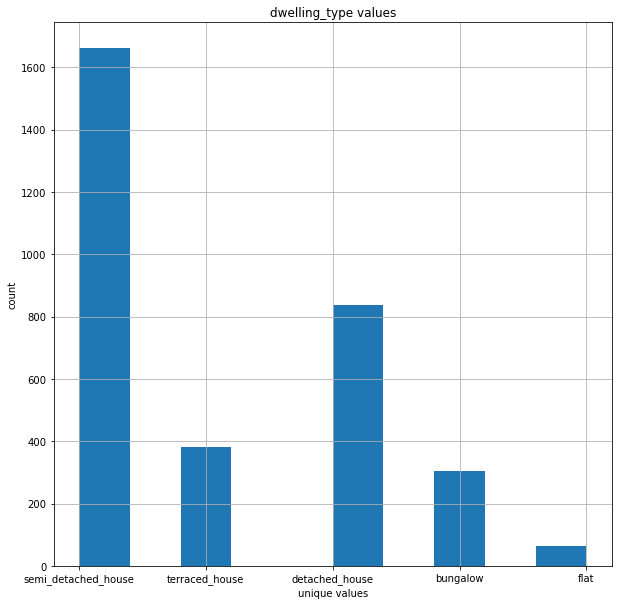

In [160]:
# plotting a histogram for each of the columns in the dataset after imputation
for column in df_info_knn_finished.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_knn_finished[column]
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/Imputed/{column}_imp_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/Imputed/{column}_imp_hist.png")
        
    plt.close(fig)

## OneHot Encoding Ready for the RNN to make use of

In [161]:
#encoding the categorical values via one hot encoding
cat_variables = df_info_knn_finished[df_info_knn_finished.loc[:,df_info_knn_finished.columns!="meter_id"].select_dtypes(include=['object']).columns] # getting the categorical columns (just 'dwelling_type')
cat_dummies = pd.get_dummies(cat_variables, drop_first=True, dummy_na=True) # getting dummies, including a separate one for na

#setting nan rows and droppoing nan column
cat_dummies.loc[cat_dummies.dwelling_type_nan==1, ["dwelling_type_detached_house","dwelling_type_flat","dwelling_type_semi_detached_house","dwelling_type_terraced_house"]]=np.nan
cat_dummies=cat_dummies.drop("dwelling_type_nan",axis=1)
cat_dummies

,dwelling_type_detached_house,dwelling_type_flat,dwelling_type_semi_detached_house,dwelling_type_terraced_house
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
3243,0.0,0.0,1.0,0.0
3244,0.0,0.0,1.0,0.0
3245,1.0,0.0,0.0,0.0
3246,0.0,0.0,1.0,0.0


In [162]:
# dropping those original columns then adding the dummy values
df_info_knn_finished = df_info_knn_finished.drop(df_info_knn_finished.loc[:,df_info_knn_finished.columns!="meter_id"].select_dtypes(include=['object']).columns, axis=1)
df_info_knn_finished = pd.concat([df_info_knn_finished, cat_dummies], axis=1)
# inspecting new state of the dataframe with the dummy variables
df_info_knn_finished

,meter_id,num_bedrooms,dwelling_type_detached_house,dwelling_type_flat,dwelling_type_semi_detached_house,dwelling_type_terraced_house
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,3.0,0.0,0.0,1.0,0.0
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,2.0,0.0,0.0,0.0,1.0
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,3.0,0.0,0.0,1.0,0.0
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,4.0,1.0,0.0,0.0,0.0
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,4.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,4.0,0.0,0.0,1.0,0.0
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,3.0,0.0,0.0,1.0,0.0
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,3.0,1.0,0.0,0.0,0.0
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,3.0,0.0,0.0,1.0,0.0


## Generating correlation plot of the features to make sure there is minimal redundancy

In [163]:
#generating the correlation matrix
corr_info = df_info_knn_finished.corr()

<AxesSubplot:>

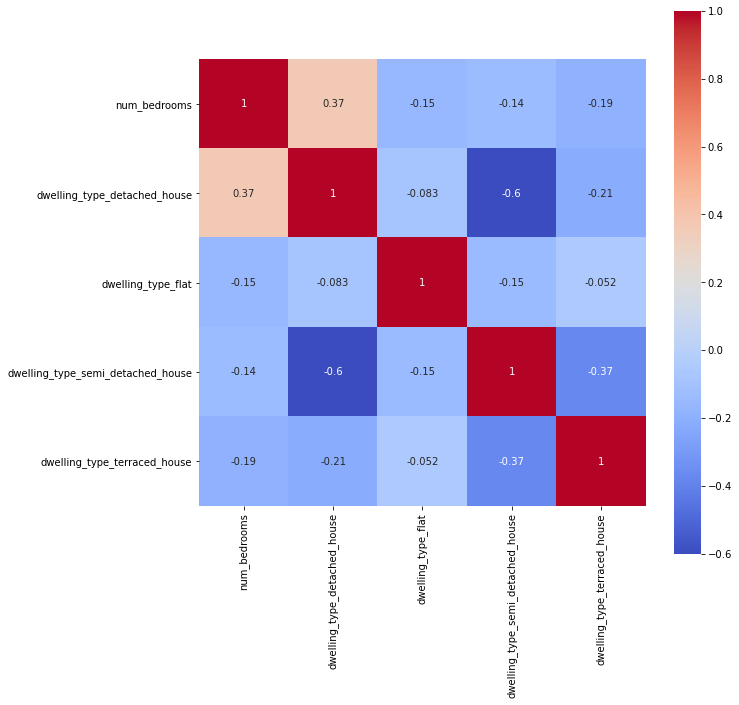

In [164]:
#generating the correlation heat map
plt.figure(figsize=(10, 10))
sns.heatmap(corr_info, cmap="coolwarm", annot=True, square=True)

In [165]:
# for each feature on the x axis
for i in range(corr_info.shape[0]):
    # for each feature after i
    for j in range(i+1, corr_info.shape[0]):
        #check if their correlation is above a threshold % (50%)
        if abs(corr_info.iloc[i,j]) >= 0.5:
            print("\nConsider ",corr_info.columns[j]," for removal as it has a high correlation with ",corr_info.columns[i]," of",round(corr_info.iloc[i,j],2),"\n")
            #set column j to be removed 
            if columns[j]:
                columns[j+1] = False #+1 for meter id
        else: 
            print("Keeping ",corr_info.columns[i]," and ",corr_info.columns[j]," have a correlation of ", round(corr_info.iloc[i,j],2))

Keeping  num_bedrooms  and  dwelling_type_detached_house  have a correlation of  0.37
Keeping  num_bedrooms  and  dwelling_type_flat  have a correlation of  -0.15
Keeping  num_bedrooms  and  dwelling_type_semi_detached_house  have a correlation of  -0.14
Keeping  num_bedrooms  and  dwelling_type_terraced_house  have a correlation of  -0.19
Keeping  dwelling_type_detached_house  and  dwelling_type_flat  have a correlation of  -0.08

Consider  dwelling_type_semi_detached_house  for removal as it has a high correlation with  dwelling_type_detached_house  of -0.6 

Keeping  dwelling_type_detached_house  and  dwelling_type_terraced_house  have a correlation of  -0.21
Keeping  dwelling_type_flat  and  dwelling_type_semi_detached_house  have a correlation of  -0.15
Keeping  dwelling_type_flat  and  dwelling_type_terraced_house  have a correlation of  -0.05
Keeping  dwelling_type_semi_detached_house  and  dwelling_type_terraced_house  have a correlation of  -0.37


##### Features don't have a particularly high correlation; no need to remove them based upon this

## Saving the finished AddInfo

In [166]:
if(os.path.exists(f"../Data/Preprocessed_Data/addInfo_knn.pkl")==False):
        df_info_knn_finished.to_pickle(f"../Data/Preprocessed_Data/addInfo_knn.pkl")